In [137]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [138]:
url = "https://github.com/swarj/MLProject/raw/main/apple_share_price.csv" #get the dataset
raw_df = pd.read_csv(url)
raw_df = raw_df.loc[::-1] #reverse order of rows to chronologically make it go from past --> present
raw_df = raw_df.assign(Time=range(len(raw_df)))
df = raw_df.reindex(['Time','Date', 'High', 'Low', 'Volume', 'Open', 'Close'], axis = 1) #make target variable last column, if we want close instead of open we can switch it
#we can try to predict the close value for the following day, need to add target close value  
df['TargetNextClose'] = df['Close'].shift(-1)
df.drop(df.tail(1).index,inplace=True) # drop last rows
df.style
print(df.head(10))
print(df.shape)
df.reset_index(inplace=True)
data_set = df.iloc[:, 0:8]
pd.set_option('display.max_columns', None)
data_set = data_set.drop(columns=["Date", "Time", "index"], axis=1)
print(data_set.head(10))

      Time       Date   High    Low     Volume   Open  Close  TargetNextClose
1663     0   3-Jan-11  47.18  46.41  111280407  46.52  47.08            47.33
1662     1   4-Jan-11  47.50  46.88   77337001  47.49  47.33            47.71
1661     2   5-Jan-11  47.76  47.07   63879193  47.08  47.71            47.68
1660     3   6-Jan-11  47.89  47.56   75106626  47.82  47.68            48.02
1659     4   7-Jan-11  48.05  47.41   77982212  47.71  48.02            48.92
1658     5  10-Jan-11  49.03  48.17  112139482  48.40  48.92            48.81
1657     6  11-Jan-11  49.28  48.50  111019993  49.27  48.81            49.20
1656     7  12-Jan-11  49.20  48.86   75644310  49.04  49.20            49.38
1655     8  13-Jan-11  49.52  49.12   74536182  49.31  49.38            49.78
1654     9  14-Jan-11  49.78  49.21   77209748  49.41  49.78            48.66
(1663, 8)
    High    Low     Volume   Open  Close
0  47.18  46.41  111280407  46.52  47.08
1  47.50  46.88   77337001  47.49  47.33
2  47.76 

In [139]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))

In [140]:
# Define the hyperparameters. These values will change based on the experiment 
hidden_layer_size = 64 # set hidden layer neurons
input_dimension = 4 # set number of input layer dimension 
l_r = 0.0001 # set learning rate
epochs = 100 # number of iterations
#################
scale_factor = 0.01 #to multiply the initial random weight values with small factor
# Define size of training set and size of testing set (80% training, 20% testing)
s = int(len(data_set) * 0.8)
# initialize weight matrices and biases with random numbers
input_hidden = np.random.randn(hidden_layer_size, input_dimension) * scale_factor # input to hidden weight
hidden_hidden = np.random.randn(hidden_layer_size, hidden_layer_size) * scale_factor # recurrent weight
hidden_output = np.random.randn(1, hidden_layer_size) * scale_factor # hidden to output determine by how much of hidden layer size
hidden_bias = np.zeros((hidden_layer_size, 1)) # hidden layer bias
output_bias = np.zeros((1, 1)) # output layer bias
# defind the forward pass function
def forward_pass(X, Y, hidden_state): 
    # X is an input sequence, 
    # Y is an output of that input sequence
    # hidden_state is a hidden state of weights

    # to store the store variables   
    store = {}  
    # initialize the hidden state and the loss  
    # store the hidden state 
    store['hidden'] = {}
    # store the input 
    store['input'] = {}
    # create a temporary hidden state form the preveious hidden state
    store['hidden'][-1] = np.copy(hidden_state)
    # set the loss to 0
    loss = 0
    # loop for forward pass
    for t in range(len(X)):
        # store the input in time step
        store['input'][t] = X[t].reshape(-1, 1)
        # store the hidden state in time step
        store['hidden'][t] = np.tanh(np.dot(input_hidden, store['input'][t]) + np.dot(hidden_hidden, store['hidden'][t-1]) + hidden_bias)
        # calculate the predicted ouput
        Y_pred = np.dot(hidden_output, store['hidden'][t]) + output_bias
        # calculate the update loss
        loss += (Y[t] - Y_pred)**2
    # this is store the predicted ouput    
    store['loss'] = loss    
    # this is store the loss  
    store['Y_pred'] = Y_pred    
    return store
# defind the backward pass function
def backward_pass(X, Y, store):
    # X is the input sequence
    # Y is an output of that input sequence
    # initialize the gradients
      # input to hidden gradient
    input_hidden_grad = np.zeros_like(input_hidden)      
      # hidden to hidden gradient
    hidden_hidden_grad = np.zeros_like(hidden_hidden)
      # hidden to output gradient    
    hidden_output_grad = np.zeros_like(hidden_output) 
      # hidden layer bias gradient   
    hidden_bias_grad = np.zeros_like(hidden_bias) 
      # output layer bias gradient       
    output_bias_grad = np.zeros_like(output_bias)   
      # next hidden state gradient     
    next_hidden_grad = np.zeros_like(store['hidden'][0]) 
    # loop for backward pass
    for t in reversed(range(len(X))):
        # calcualte the derivative of the loss
        dy = -2 * (Y[t] - store['Y_pred'])
        hidden_output_grad += np.dot(dy, store['hidden'][t].T)
        output_bias_grad += dy
        # calculate the derivative of the hidden state
        delta_hidden = np.dot(hidden_output.T, dy) + next_hidden_grad
        raw_hidden = (1 - store['hidden'][t]**2) * delta_hidden
        # Update the gradients for the hidden layer
        hidden_bias_grad += raw_hidden
        input_hidden_grad += np.dot(raw_hidden, store['input'][t].T)
        hidden_hidden_grad += np.dot(raw_hidden, store['hidden'][t-1].T)
        next_hidden_grad = np.dot(hidden_hidden.T, raw_hidden)
    # clip the gradients to prevent it from becoming too large during training
    for dparam in [input_hidden_grad, hidden_hidden_grad, hidden_output_grad, hidden_bias_grad, output_bias_grad]:
        np.clip(dparam, -5, 5, out=dparam)        
    return input_hidden_grad, hidden_hidden_grad, hidden_output_grad, hidden_bias_grad, output_bias_grad
# set the initial hidden state to None
hidden_state = np.zeros((hidden_layer_size, 1))
data = data_set
data = sc.fit_transform(data)
data = pd.DataFrame(data)
#split the dataset into testing and training
X = np.array(data.iloc[:, :-1])[:s]                     #Training set for the input attributes
X_test = np.array(data.iloc[:, :-1])[s:]                #Testing set for the input attributes
Y = np.array(data.iloc[:, -1]).reshape(-1, 1)[:s]       #Training set for output
Y_test = np.array(data.iloc[:, -1]).reshape(-1, 1)[s:]  #Testing set for output
# create an empty list for loss
loss_his = []
test_loss_his = []
#training 
for i in range(epochs):    
    store = forward_pass(X, Y, hidden_state)
    input_hidden_grad, hidden_hidden_grad, hidden_output_grad, hidden_bias_grad, output_bias_grad = backward_pass(X, Y, store)
    input_hidden = input_hidden - (l_r * input_hidden_grad)
    hidden_hidden = hidden_hidden - (l_r * hidden_hidden_grad)
    hidden_output = hidden_output - (l_r * hidden_output_grad)
    hidden_bias = hidden_bias - (l_r * hidden_bias_grad)
    output_bias = output_bias - (l_r * output_bias_grad)
    hidden_state = store['hidden'][len(X) - 1]
    # adding the value of the loss
    loss_his.append(store['loss'])
    # compute loss on testing set 
    test_store = forward_pass(X_test, Y_test, hidden_state)
    test_loss = test_store['loss'][0][0] 
    test_loss_his.append(test_loss)

    if i % 10 == 0:
        print('Training Loss:', store['loss'])
        print('Test Loss:', test_loss)
# flatten the loss history arrays
train_losses = np.array(loss_his).flatten()
test_losses = np.array(test_loss_his).flatten()

Training Loss: [[206.91218674]]
Test Loss: 157.21972295222253
Training Loss: [[194.54253416]]
Test Loss: 149.47650322347016
Training Loss: [[177.25934202]]
Test Loss: 138.31002435190686
Training Loss: [[153.99234064]]
Test Loss: 122.88456108056258
Training Loss: [[124.56274605]]
Test Loss: 102.70059559929452
Training Loss: [[89.4331856]]
Test Loss: 77.37202465991163
Training Loss: [[52.21930291]]
Test Loss: 48.206255858903994
Training Loss: [[27.30739399]]
Test Loss: 26.33358938355274
Training Loss: [[18.44536695]]
Test Loss: 18.275664490724985
Training Loss: [[15.29472208]]
Test Loss: 15.453920425172205


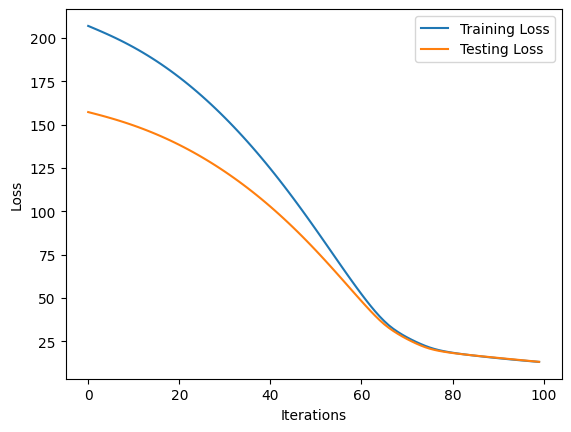

Mean Squared Error: 0.07620259274217342


In [141]:
# plot
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()       
# predict the test set
Y_preds = []
for t in range(len(X_test)):
    #obtain values from the forward pass on the testing sets
    store = forward_pass([X_test[t]], [Y_test[t]], hidden_state)
    #append the prediction values of Y
    Y_preds.append(store['Y_pred'])
# calculate the MSE
MSE = np.mean((Y_test - Y_preds)**2)
print('Mean Squared Error:', MSE)

In [142]:
min_val = 45.05             #Min value in the dataframe
max_val = 161.06            #Max value in the dataframe
results = []                #denormalization of values
for i in Y_preds:
  results.append((i * (max_val - min_val)) + min_val)   #use previous values of min and max to get the prediction denormalized
print(results)

[array([[93.20880654]]), array([[92.97375613]]), array([[92.81216295]]), array([[92.61057549]]), array([[92.16176668]]), array([[92.05762369]]), array([[91.72940846]]), array([[88.34879754]]), array([[88.3989767]]), array([[87.30797022]]), array([[87.2922431]]), array([[87.68334752]]), array([[87.92730977]]), array([[87.38617256]]), array([[87.07187522]]), array([[87.21108088]]), array([[87.1607491]]), array([[87.25011968]]), array([[86.43052142]]), array([[86.12317772]]), array([[86.96289689]]), array([[87.54331204]]), array([[87.69809715]]), array([[87.69595434]]), array([[87.92150849]]), array([[88.45401848]]), array([[88.92747123]]), array([[89.50321096]]), array([[89.76638721]]), array([[89.8659235]]), array([[89.79516586]]), array([[89.59204595]]), array([[88.89420417]]), array([[89.13909639]]), array([[89.69200823]]), array([[89.78173174]]), array([[89.6779984]]), array([[89.61149216]]), array([[89.50937429]]), array([[89.2870129]]), array([[88.9951791]]), array([[89.10157415]])